In [55]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import ruptures as rpt
import time as t
from datetime import datetime




global columns
columns = ["time", "device_id", "mac_address", "hostname", "signal_strength", "packets_sent", "packets_received", "bytes_sent", "bytes_received", "errors_sent", "errors_received", "radio_connected", "time_since_connected"]# Connection parameters
conn_params = {
    "host": "10.246.3.111",       # e.g., "127.0.0.1" or server IP
    "port": 5432,           # default PostgreSQL port
    "database": "bulkdata_genie", # database name
    "user": "postgres",   # your username
    "password": "landufrj123"# your password
}
def get_df():
    conn = get_db_connection()
    if conn is None:
        return None
    
    query = """
    SELECT *
    FROM wifi_stats """
    
    with conn.cursor() as cursor:
        cursor.execute(query)
        results = cursor.fetchall()
        df = pd.DataFrame(results, columns=columns)
    conn.close()
    return df    
# Establish connection
def get_db_connection():
    try:
        conn = psycopg2.connect(**conn_params)
        #print("Connection successful!")
        return conn
    except Exception as e:
        #print("Error connecting to TimeScaleDB:", e)
        return None

df = get_df()

df.rename(columns={'bytes_sent': 'bytes_received', 'bytes_received': 'bytes_sent'}, inplace=True)

def convert_column_to_unix(df, column_name, timestamp_format, timezone='UTC'):
    """
    Convert a column of timestamps in a DataFrame to Unix timestamps.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the timestamp column.
        column_name (str): The name of the column to convert.
        timestamp_format (str): The format of the timestamps (e.g., "%Y-%m-%d %H:%M:%S").
        timezone (str): The timezone of the timestamps if they are naive. Options: 'UTC' or 'local'.

    Returns:
        pd.Series: A new column with Unix timestamps.
    """
    # Convert the column to datetime objects
    df[column_name] = pd.to_datetime(df[column_name], format=timestamp_format)

    # Handle timezone
    if timezone == 'UTC':
        # If timestamps are naive, assume they are in UTC
        df[column_name] = df[column_name].dt.tz_localize('UTC')
    elif timezone == 'local':
        # If timestamps are naive, assume they are in local time
        df[column_name] = df[column_name].dt.tz_localize(None).dt.tz_localize('UTC', ambiguous='infer')
    else:
        raise ValueError("Invalid timezone. Use 'UTC' or 'local'.")

    # Convert to Unix timestamps
    df['unix_timestamp'] = df[column_name].astype(int) / 10**9  # Convert nanoseconds to seconds

    return df

df['time'] = convert_column_to_unix(df, 'time', '%Y-%m-%d %H:%M:%S-03', timezone='local')['unix_timestamp']
print(len(df))
df2 = df[df['time'] > 1739430000]
df = df2
print(len(df))
hosts = df['hostname'].unique()
macs = df['mac_address'].unique()
people = []
host_dataframes = {}
for host in hosts:
    host_dataframes[host] = df[df["hostname"] == host]
    people.append(host_dataframes[host])

mac_dataframes = {}
people2 = []
for x in people:
    if len(x['mac_address'].unique()) > 1:
        macs = x['mac_address'].unique()
        for mac in macs:
            mac_dataframes[mac] = x[x["mac_address"] == mac]
            people2.append(mac_dataframes[mac])
    else:
        people2.append(x)

people = people2



def tratamento(lista, apply_log=False, apply_scaler=False):
    for data in lista:
        data.sort_values(by='time', inplace=True)
        data.loc[:, 'bytes_sent_per_minute'] = data['bytes_sent'].diff()
        data.loc[:, 'bytes_received_per_minute'] = data['bytes_received'].diff()
        data.loc[:, 'total_bytes_per_minute'] = data['bytes_sent_per_minute'] + data['bytes_received_per_minute']
        
        if apply_log:
            data['bytes_sent_per_minute'] = np.log([data['bytes_sent_per_minute'].iloc[i] if data['bytes_sent_per_minute'].iloc[i] > 0 else 0 for i in range(len(data['bytes_sent_per_minute']))])
            data['bytes_received_per_minute'] = np.log([data['bytes_received_per_minute'].iloc[i] if data['bytes_received_per_minute'].iloc[i] > 0 else 0 for i in range(len(data['bytes_received_per_minute']))])
            data['total_bytes_per_minute'] = np.log([data['total_bytes_per_minute'].iloc[i] if data['total_bytes_per_minute'].iloc[i] > 0 else 0 for i in range(len(data['total_bytes_per_minute']))])
        else:
            data['bytes_sent_per_minute'] = [data['bytes_sent_per_minute'].iloc[i] if data['bytes_sent_per_minute'].iloc[i] > 0 else 0 for i in range(len(data['bytes_sent_per_minute']))]
            data['bytes_received_per_minute'] = [data['bytes_received_per_minute'].iloc[i] if data['bytes_received_per_minute'].iloc[i] > 0 else 0 for i in range(len(data['bytes_received_per_minute']))]
            data['total_bytes_per_minute'] = [data['total_bytes_per_minute'].iloc[i] if data['total_bytes_per_minute'].iloc[i] > 0 else 0 for i in range(len(data['total_bytes_per_minute']))]
        
        if apply_scaler:
            scaler = MinMaxScaler()
            data[['bytes_sent_per_minute', 'bytes_received_per_minute','total_bytes_per_minute']] = scaler.fit_transform(data[['bytes_sent_per_minute', 'bytes_received_per_minute','total_bytes_per_minute']])

tratamento(people)

for i in range(len(people)):
    if people[i]['hostname'].iloc[0] == 'TV':
        people.pop(i)
        break

29370
2667


/tmp/ipykernel_68882/3321610160.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.sort_values(by='time', inplace=True)
/tmp/ipykernel_68882/3321610160.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, 'bytes_sent_per_minute'] = data['bytes_sent'].diff()
/tmp/ipykernel_68882/3321610160.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

In [60]:
def plot(dfa, apply_log=False):
    if apply_log:
        plt.figure(figsize=(12, 6))
        plt.plot(dfa['time'], np.log(dfa['bytes_sent_per_minute']), label='Bytes Sent')
        plt.plot(dfa['time'], np.log(dfa['bytes_received_per_minute']), label='Bytes Received')
        plt.plot(dfa['time'], np.log(dfa['total_bytes_per_minute']), label='Total Bytes')
        plt.xlabel('Time')
        plt.ylabel('Bytes (log scale)')
        plt.title(f'Bytes Sent and Received Over Time {dfa["hostname"].iloc[0]}, {dfa["mac_address"].iloc[0]}')
        plt.xticks(rotation=90)  # Rotate x-axis labels vertically
        plt.legend()
        plt.tight_layout()  # Add padding for better label spacing
        plt.show()
    else:
        plt.figure(figsize=(12, 6))
        plt.plot(dfa['time'], dfa['bytes_sent_per_minute'], label='Bytes Sent')
        plt.plot(dfa['time'], dfa['bytes_received_per_minute'], label='Bytes Received')
        plt.plot(dfa['time'], dfa['total_bytes_per_minute'], label='Total Bytes')
        plt.xlabel('Time')
        plt.ylabel('Bytes')
        plt.title(f'Bytes Sent and Received Over Time {dfa["hostname"].iloc[0]}, {dfa["mac_address"].iloc[0]}')
        plt.xticks(rotation=90)  # Rotate x-axis labels vertically
        plt.legend()
        plt.tight_layout()  # Add padding for better label spacing
        plt.show()



In [61]:
def convert_unix_to_timestamp(df, output_format="%Y-%m-%d %H:%M:%S", target_timezone='local'):
    """
    Convert a column of Unix timestamps in a DataFrame to human-readable timestamps.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the Unix timestamp column.
        unix_column (str): The name of the column with Unix timestamps.
        output_format (str): The desired output format for the timestamps (e.g., "%Y-%m-%d %H:%M:%S").
        target_timezone (str): The timezone for the output timestamps. Options: 'UTC' or 'local'.

    Returns:
        pd.DataFrame: The DataFrame with a new column containing human-readable timestamps.
    """
    # Convert Unix timestamps to datetime objects
    df['time'] = pd.to_datetime(df['time'], unit='s', origin='unix')

    # Handle timezone
    if target_timezone == 'UTC':
        df['time'] = df['time'].dt.tz_localize('UTC')
    elif target_timezone == 'local':
        df['time'] = df['time'].dt.tz_localize('UTC').dt.tz_convert(None)  # Convert to local time
    else:
        raise ValueError("Invalid target_timezone. Use 'UTC' or 'local'.")

    # Format the timestamps as strings
    df['time'] = df['time'].dt.strftime(output_format)

    return df


In [138]:
def cp(dfa, x, column, graph=False):
    data = dfa[x][column].values.reshape(-1, 1)
    algo = rpt.Pelt(model="rbf").fit(data)
    change_points = algo.predict(pen=2.75)  # Now returns the array
    if graph:
        rpt.show.display(data, change_points, figsize=(10, 6))
        print(change_points)
        host = dfa[x]["hostname"].iloc[0]
        mac = dfa[x]["mac_address"].iloc[0]
        plt.title(f'Change Point Detection in {column} for {host} / {mac}')
        plt.show()
    return change_points  # No trailing comma
#cp(people, 19, 'total_bytes_per_minute', graph=True)
coluna = 'total_bytes_per_minute'
clusters = []
for i in range(len(people)):
    change_points = cp(people, i, coluna, False)  # Now an array, not a tuple
    for x in range(1, len(change_points)):
        temp = people[i].iloc[change_points[x-1]:change_points[x]]
        clusters.append(temp)
    #print(f'coluna {coluna} host {people[i]["hostname"].iloc[0]} done')



In [139]:
lista = [0,1,3,4,8,9,12,15,17,18,20,26,28,30,32]
serve = []
for i in range(len(clusters)):
    if i in lista:
        #plot(clusters[i])
        print(f'cluster {i} done')
        serve.append(clusters[i])
print(len(serve))


cluster 0 done
cluster 1 done
cluster 3 done
cluster 4 done
cluster 8 done
cluster 9 done
cluster 12 done
cluster 15 done
cluster 17 done
cluster 18 done
cluster 20 done
cluster 26 done
cluster 28 done
cluster 30 done
cluster 32 done
15


In [140]:
import os

def list_files_in_directory(path):
    lista = []
    try:
        files = os.listdir(path)
        for file in files:
            lista.append(str(file))
    except Exception as e:
        print(f"Error: {e}")
    return lista

# Example usage
path = '/home/localuser/testes_11_2'
files = sorted(list_files_in_directory(path))
sorted_files = sorted(files, key=lambda x: int(x.split('_')[1].split('.')[0]))
sorted_files = [path + '/' + x for x in sorted_files]
files = [pd.read_csv(x) for x in sorted_files]
clusters = files + serve


In [141]:
main = {'clusters':clusters,
        'labels':[]}

In [142]:
x = 'streaming, streaming, streaming, streaming, streaming, streaming, streaming, streaming, video call, social network, social network, social network, video call, video game, streaming, streaming, video call, streaming, streaming, streaming, streaming, streaming, streaming, streaming, streaming, live stream, streaming, streaming, streaming,' + ' video call, video call, social network, social network, social network, social network, live stream, social network, live stream, live stream, video call, live stream, video call, live stream, live stream'
x = x.split(', ')
print(len(x))
main['labels'] = x

print(main['labels'])


44
['streaming', 'streaming', 'streaming', 'streaming', 'streaming', 'streaming', 'streaming', 'streaming', 'video call', 'social network', 'social network', 'social network', 'video call', 'video game', 'streaming', 'streaming', 'video call', 'streaming', 'streaming', 'streaming', 'streaming', 'streaming', 'streaming', 'streaming', 'streaming', 'live stream', 'streaming', 'streaming', 'streaming', 'video call', 'video call', 'social network', 'social network', 'social network', 'social network', 'live stream', 'social network', 'live stream', 'live stream', 'video call', 'live stream', 'video call', 'live stream', 'live stream']


In [143]:
main.keys()

dict_keys(['clusters', 'labels'])

In [144]:
print(len(main['labels']))
print(len(main['clusters']))


44
44


In [145]:
data = []

for cluster in main['clusters']:
    temp={
        'sent_mean':cluster['bytes_sent_per_minute'].mean(),
        'sent_std':cluster['bytes_sent_per_minute'].std(),
        'received_mean':cluster['bytes_received_per_minute'].mean(),
        'received_std':cluster['bytes_received_per_minute'].std(),
    }
    data.append(temp)
main['data'] = data



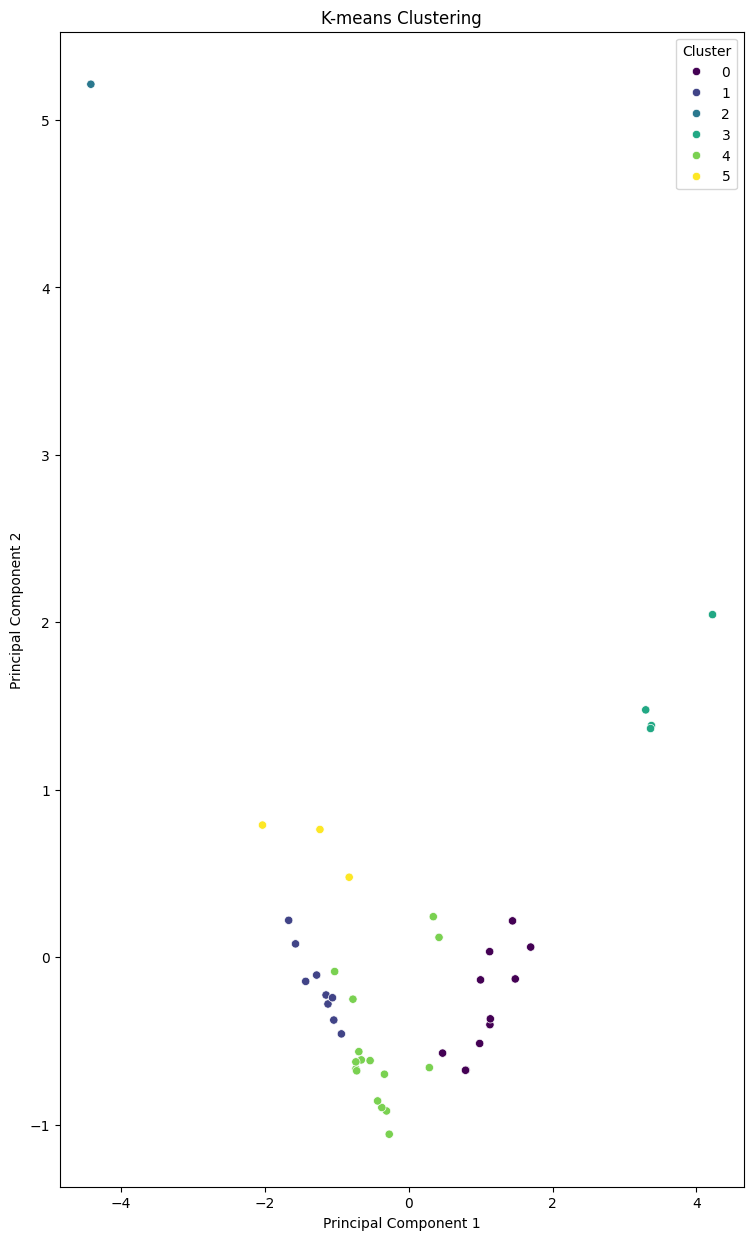

                    PC1       PC2
sent_mean     -0.527919  0.361608
sent_std      -0.371850  0.715076
received_mean  0.535796  0.421248
received_std   0.544014  0.424801


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Assuming 'main' is a dictionary containing your data under the key 'data'
data = main['data']
df = pd.DataFrame(data)

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)
df_pca = pd.DataFrame(principal_components, columns=['PC1', 'PC2'])

kmeans = KMeans(n_clusters=len(set(x)), random_state=42)
clusters = kmeans.fit_predict(scaled_data)
df_pca['Cluster'] = clusters

# Split data into features (PCA components) and labels (K-means clusters)
X = df_pca[['PC1', 'PC2']]
y = df_pca['Cluster']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Create a mesh grid for plotting
x_min, x_max = X['PC1'].min() - 1, X['PC1'].max() + 1
y_min, y_max = X['PC2'].min() - 1, X['PC2'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))


plt.figure(figsize=(30, 15))

# K-means Clustering Plot
plt.subplot(1, 3, 1)
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=df_pca, palette='viridis')
plt.title('K-means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.show()

# After fitting PCA (from your earlier code):
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)

# Get feature contributions to each principal component
loadings = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=df.columns  # Original feature names (e.g., sent_mean, sent_std, etc.)
)
print(loadings)

In [157]:
main['results'] = clusters

In [158]:
main = pd.DataFrame(main)

In [159]:
print(main[['labels', 'results']])

            labels  results
0        streaming        4
1        streaming        4
2        streaming        1
3        streaming        4
4        streaming        5
5        streaming        4
6        streaming        1
7        streaming        5
8       video call        4
9   social network        4
10  social network        4
11  social network        4
12      video call        0
13      video game        2
14       streaming        4
15       streaming        1
16      video call        0
17       streaming        4
18       streaming        4
19       streaming        1
20       streaming        4
21       streaming        1
22       streaming        1
23       streaming        1
24       streaming        4
25     live stream        1
26       streaming        5
27       streaming        4
28       streaming        1
29      video call        0
30      video call        0
31  social network        0
32  social network        0
33  social network        0
34  social network  